In [138]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pandas.plotting import autocorrelation_plot


import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import  rcParams
rcParams['figure.figsize'] = 15,6

import warnings 
warnings.filterwarnings('ignore')


In [18]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [58]:
df = pd.read_csv('zinc_prices_IMF.csv')
df.head()

,Date,Price
0,1-Jan-80,773.82
1,1-Feb-80,868.62
2,1-Mar-80,740.75
3,1-Apr-80,707.68
4,1-May-80,701.07


In [59]:
df.set_index(pd.to_datetime(df.Date), inplace=True)
df.drop('Date', inplace=True, axis=1)
df.describe()

,Price
count,434.000000
mean,1362.338594
std,677.071321
min,597.450000
25%,875.355000
50%,1088.875000
75%,1742.052500
max,4381.450000


In [61]:
df.head(12)

,Price
Date,
1980-01-01,773.82
1980-02-01,868.62
1980-03-01,740.75
1980-04-01,707.68
1980-05-01,701.07
1980-06-01,676.82
1980-07-01,712.09
1980-08-01,767.21
1980-09-01,795.87


<AxesSubplot:xlabel='Date'>

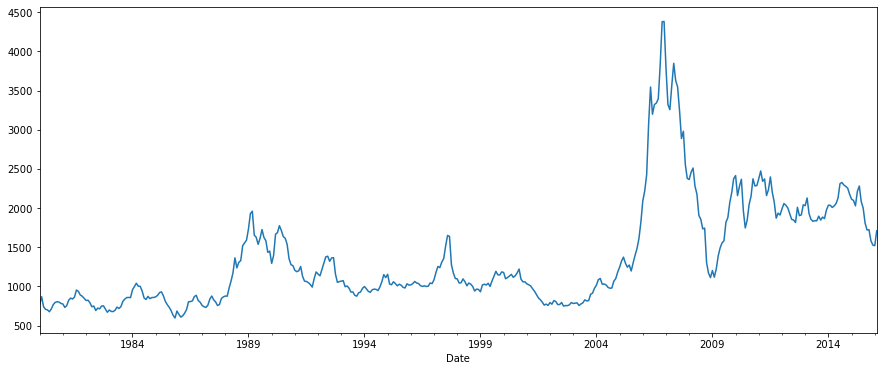

In [14]:
ts = df['Price']
ts.plot()

In [120]:
print('start year: ',df.index.year.values.min(), 'end year: ', df.index.year.values.max())
with pd.option_context('display.max_columns', None):
    display(df.groupby(df.index.year).count().T) # 2016 has only 2 month entries

start year:  1980 end year:  2016


Date,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Price,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,2


In [125]:
years = pd.DataFrame(index=range(1,13))
for year, val in df.groupby(df.index.year):
    if year != 2016 :
        years[year] =val.Price.values # extaract prices for each year excluding 2016
years.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
1,773.82,776.03,820.12,698.86,956.81,866.42,643.75,758.39,877.44,1732.83,...,2091.77,3784.86,2364.41,1202.52,2414.69,2375.81,1989.23,2031.41,2036.93,2113.05
2,868.62,731.93,824.53,681.23,998.69,886.26,608.48,740.75,875.23,1929.50,...,2219.75,3321.38,2458.48,1118.00,2158.82,2473.45,2057.79,2128.69,2034.53,2097.76
3,740.75,756.18,791.46,679.02,1040.58,921.53,626.11,731.93,981.06,1959.91,...,2427.66,3256.18,2511.18,1223.22,2277.29,2341.48,2035.93,1929.15,2007.90,2028.73
4,707.68,824.53,740.75,696.66,1003.10,930.35,659.18,760.59,1069.24,1654.40,...,3068.34,3566.86,2278.51,1388.14,2367.53,2371.48,2002.68,1855.60,2027.21,2212.73
5,701.07,850.98,749.57,736.34,1000.90,879.64,707.68,837.76,1175.06,1627.00,...,3544.64,3847.52,2178.33,1491.89,1969.82,2159.60,1928.01,1831.01,2058.98,2281.80


***
> ### There is sudden spike in year range 2004-2009, plot details ->
***

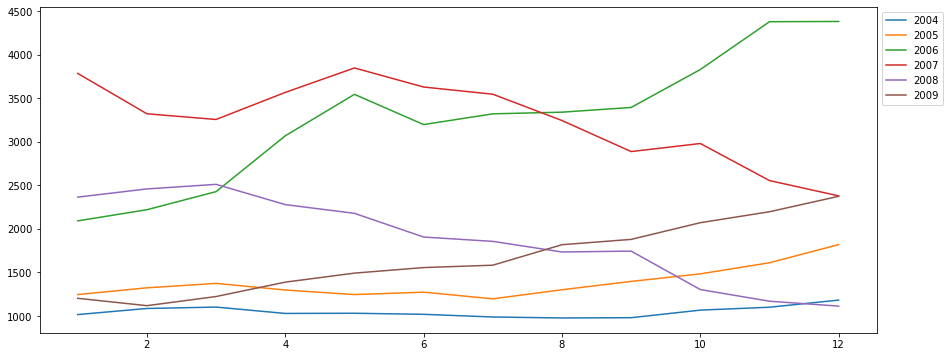

In [136]:
years.loc[:, 2004:2009].plot().legend(bbox_to_anchor=(1,1))

***
## Observations:
* ### year 2004 started with price of apprx 1000, ended at around 1100 not so much activity
* ### 2005 picked price from end of 2004 approx and ended at aprx 1700, within a period of 24 months price shoots from 1000, 1700 (typically happens when earth metals becomes rare)
* ### 2006 picks at higher price than end of 2005 approx 2000, ends at 4500 (this is the sudden rise in price)
* > ### A google search on this reveals -> `On the LME, zinc prices touched a historical high of $4,580 per tonne in 2006 on account of metal deficit in the global markets`
* ### 2007 to 2008 there is a systematic decline and price drops dead in dec 2008(reaches same level as 2004)
* ### 2009 picks up again with ending price of apprx 2300 
***

In [158]:
decomp = seasonal_decompose(ts)

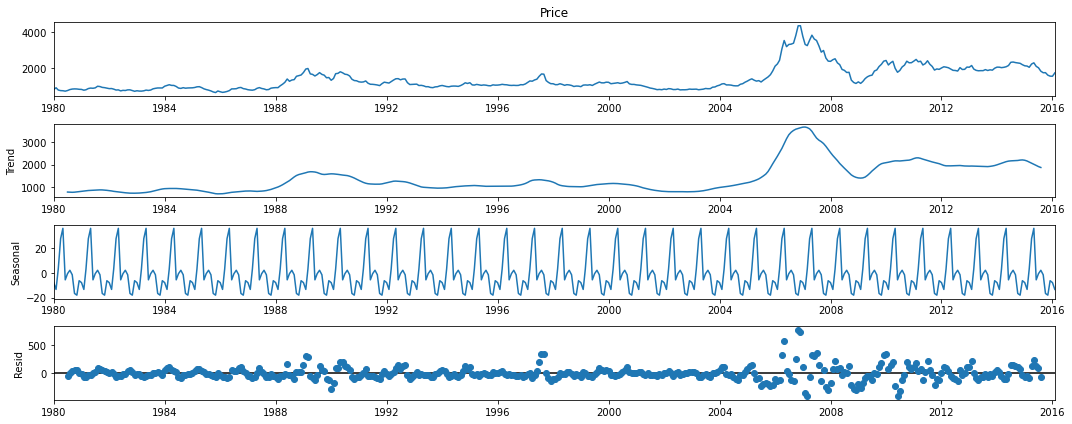

In [159]:
decomp.plot(); #semicolon stops printing repeat plots

***
## Non stationary properies( mean, variance do not change over time)
* ### Trend has a range of 1000$ to 4000$ and the mean remains constant most of the time
* ### Residual: Most of the residuals fall around mean except for year 2006-2009 and little around 1989-1991
* ### Seasonal : There is very less seasonality around 20 so not much difference
***

<AxesSubplot:>

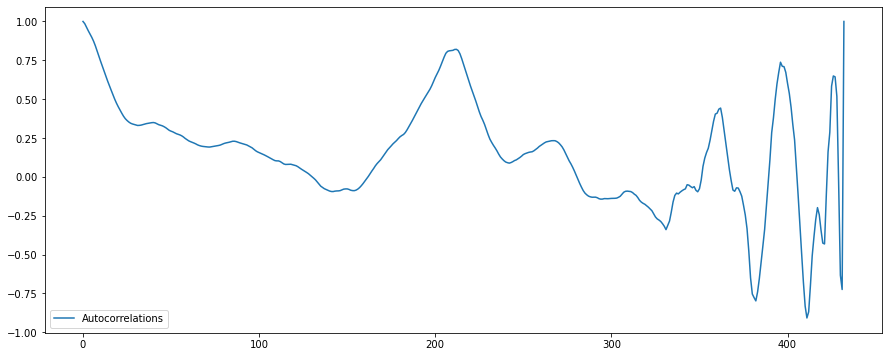

In [165]:
# plot Autocorrelations amongst Price
acs = pd.DataFrame({'Autocorrelations': [df.Price.autocorr(n) for n in range(434)]})
acs.plot()


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

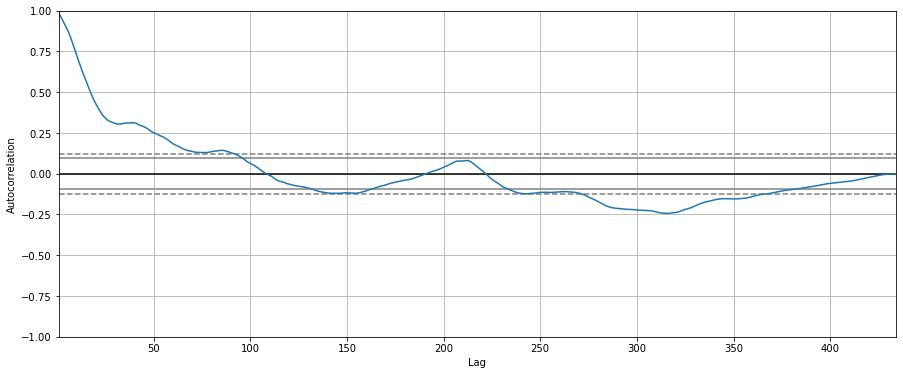

In [166]:
# Autocorrelation in Price another way
autocorrelation_plot((df['Price']))

***
>There is not pattern repeating for autocorrelation
***

***
## Statistical test for Stationarity
***

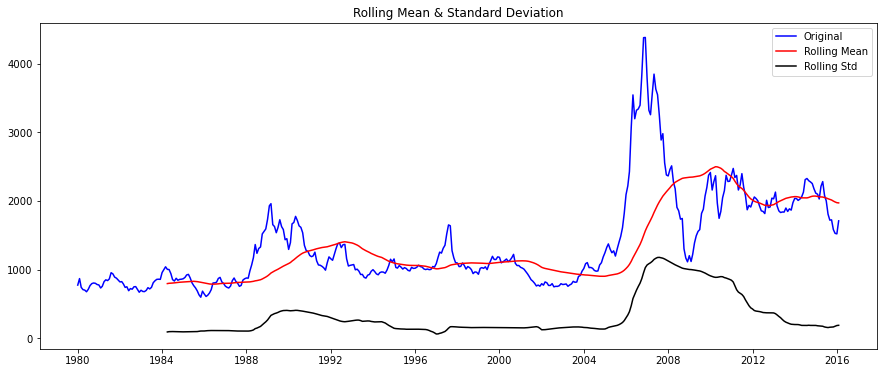

Results of Dickey-Fuller Test:
Test Statistic                  -3.139601
p-value                          0.023758
#Lags Used                       7.000000
Number of Observations Used    426.000000
Critical Value (1%)             -3.445794
Critical Value (5%)             -2.868349
Critical Value (10%)            -2.570397
dtype: float64


In [19]:
test_stationarity(df['Price'])

***
> ### Test statistics < 5% Critical value so NULL hypothesis of DF test cannot be rejected, Timesseries is already stationary
> ### Try for better statistics by still treating it as non-stationary
***

<AxesSubplot:xlabel='Date'>

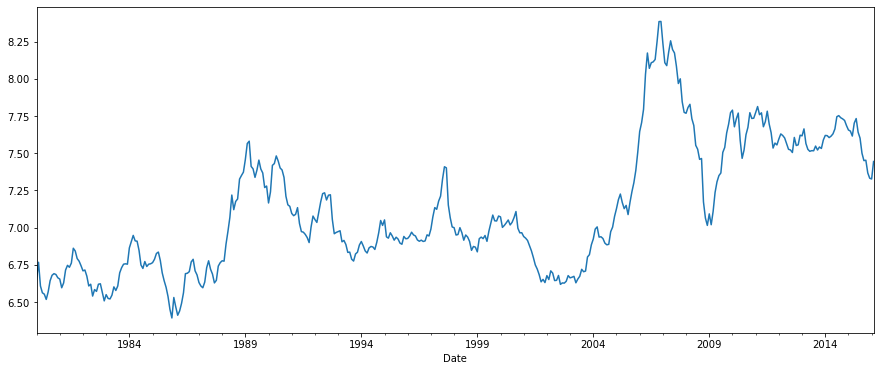

In [17]:
ts_log = np.log(ts)
ts_log.plot()

<AxesSubplot:>

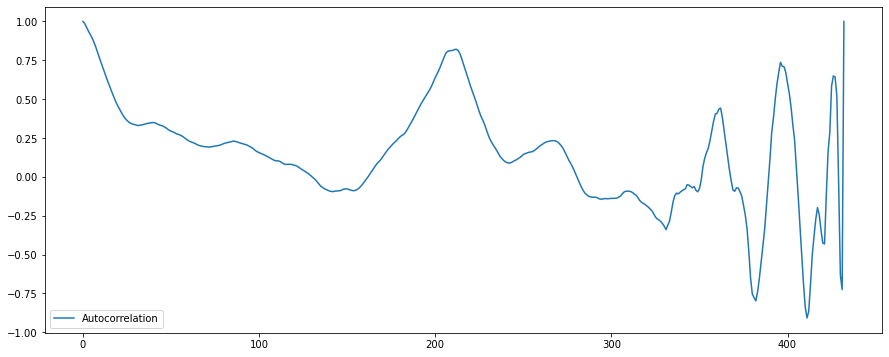

In [174]:
acs_log = pd.DataFrame({"Autocorrelation": [ts.autocorr(n) for n in range(434)]})
acs_log.plot()

<AxesSubplot:xlabel='Date'>

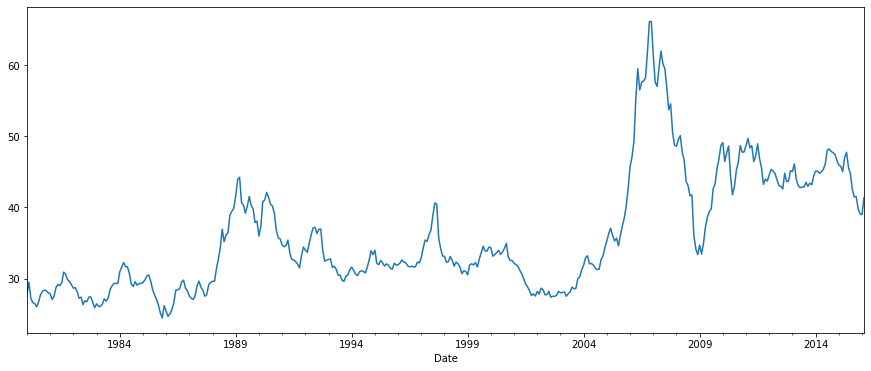

In [175]:
ts_sqrt = np.sqrt(ts)
ts_sqrt.plot()

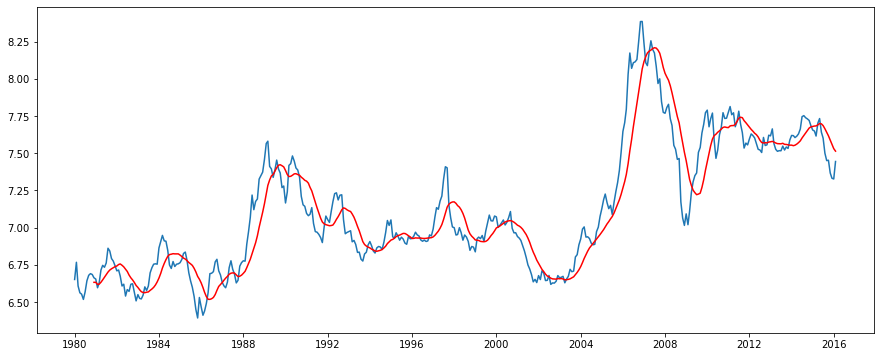

In [20]:
movingaverage = ts_log.rolling(window=12).mean()
movingstd = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingaverage, color='red')

In [32]:
# difference between actual nuber of price and moving average
ts_log_mv_diff = ts_log - movingaverage
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head()


Date
1980-12-01    0.030472
1981-01-01    0.021753
1981-02-01   -0.022485
1981-03-01    0.008392
1981-04-01    0.082191
Name: Price, dtype: float64

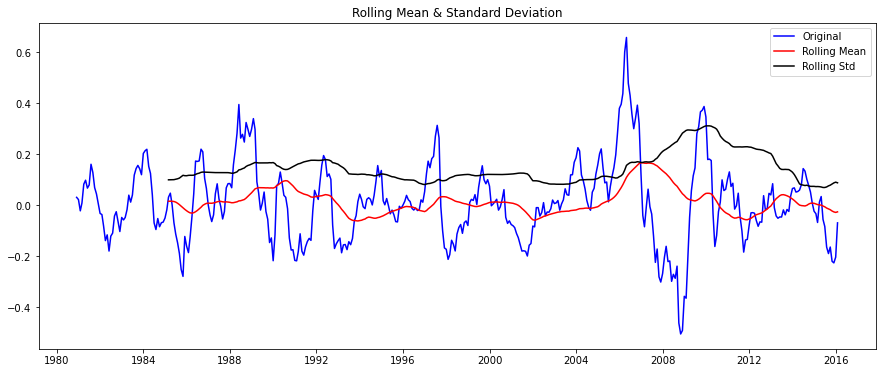

Results of Dickey-Fuller Test:
Test Statistic                -5.898484e+00
p-value                        2.814411e-07
#Lags Used                     4.000000e+00
Number of Observations Used    4.180000e+02
Critical Value (1%)           -3.446091e+00
Critical Value (5%)           -2.868479e+00
Critical Value (10%)          -2.570466e+00
dtype: float64


In [33]:
test_stationarity(ts_log_mv_diff)

***
> > > ### Test statistics < 1% Critical value so NULL hypothesis of DF test cannot be rejected, Timesseries is now stationary
***

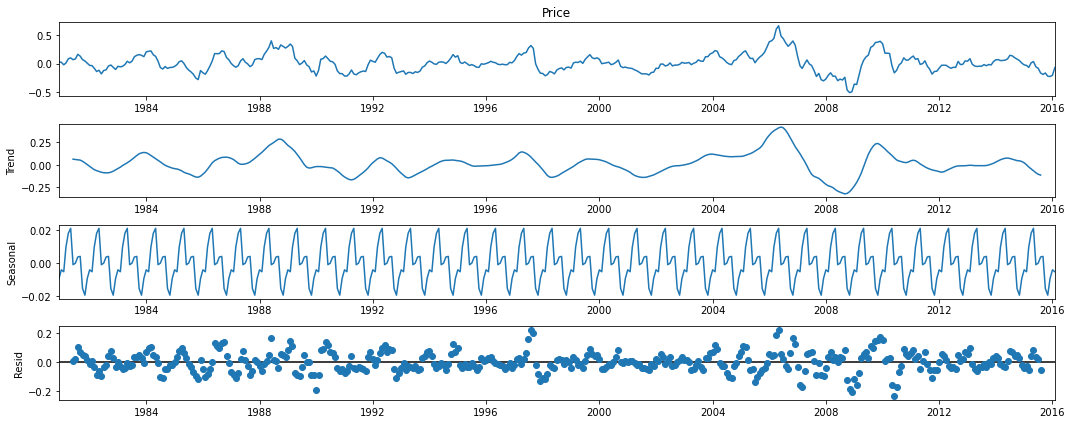

In [157]:
decomp_ts_log_mv_diff = seasonal_decompose(ts_log_mv_diff)
decomp_ts_log_mv_diff.plot();

In [ ]:
autocorrelation_plot(decomp_ts_log_mv_diff.seasonal)

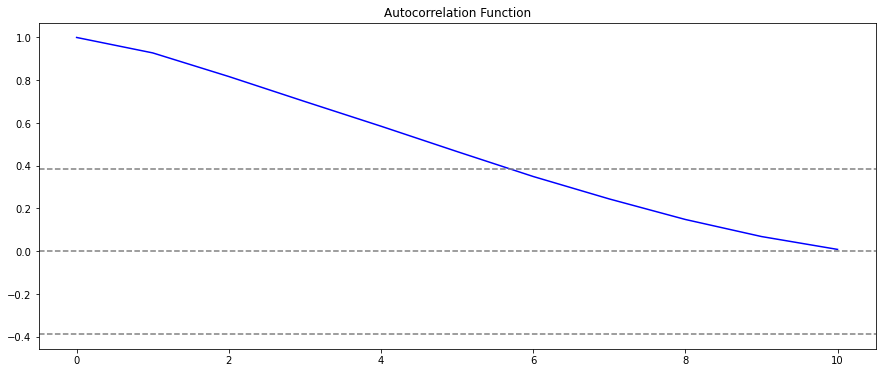

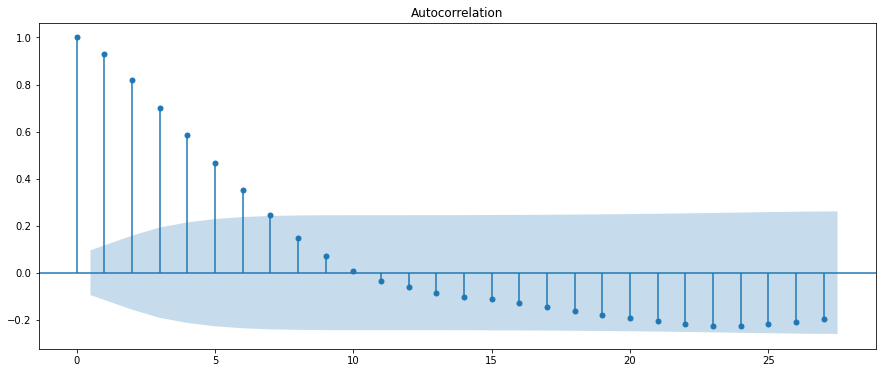

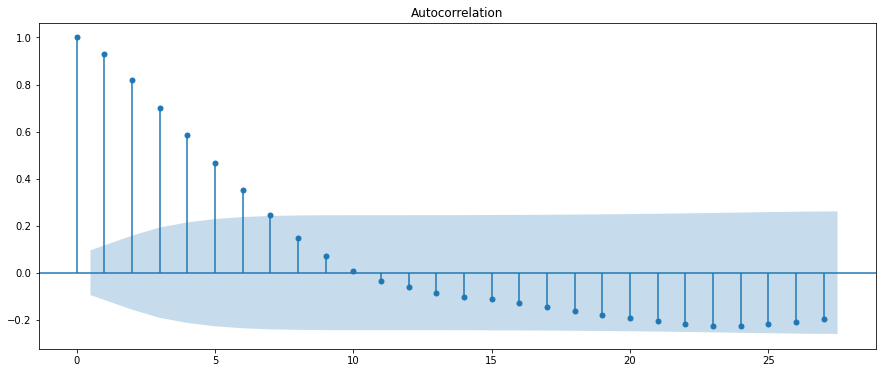

In [152]:
# acf plot
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags = 10), color='blue')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.axhline(y= 7.96/np.sqrt(len(ts_log_mv_diff)), linestyle = '--', color='gray')
plt.title('Autocorrelation Function')
plt.show()

plot_acf(ts_log_mv_diff); # semicoloon probably stops printing repeat plots


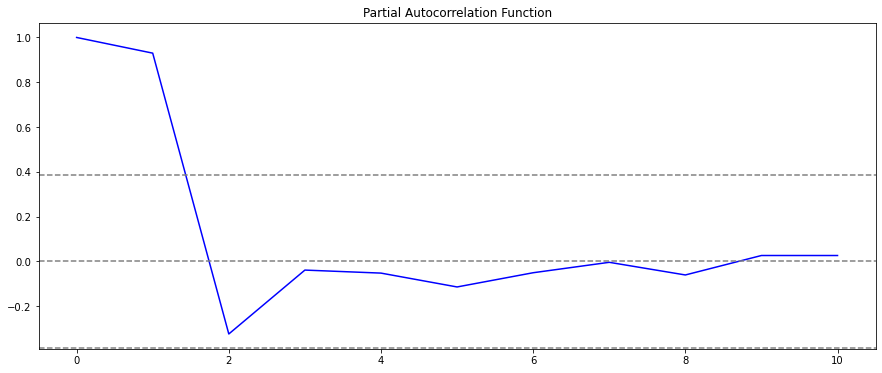

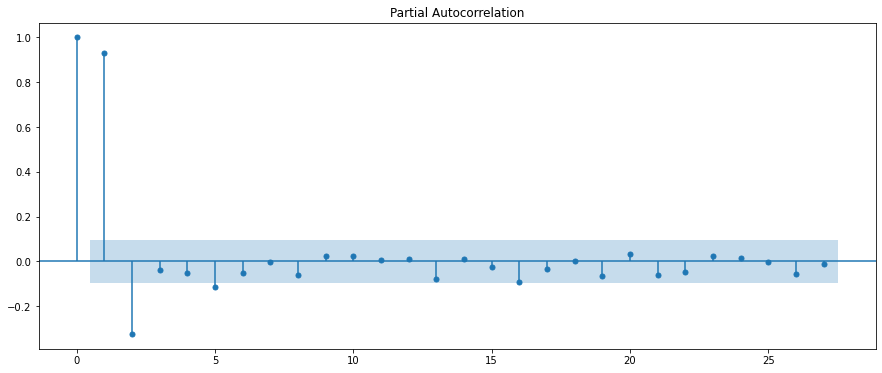

In [150]:
# pacf plot
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags=10), color='blue')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

# curve drops to 0 between 1 and 2 lags hence p can be 1 or 2

plot_pacf(ts_log_mv_diff); # semicoloon stops printing repeat plots

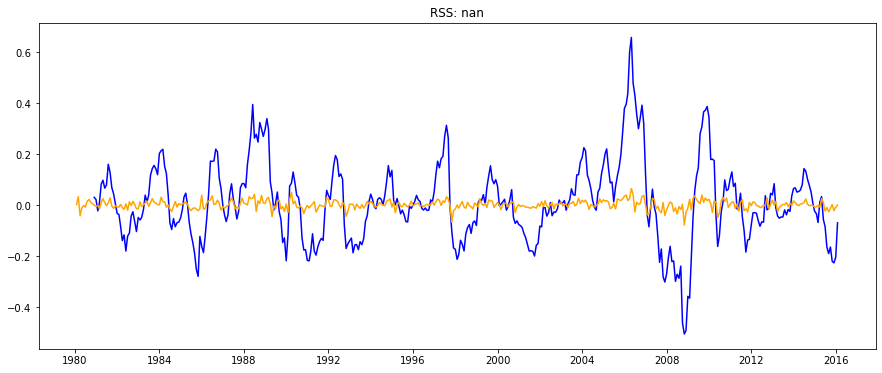

In [37]:
model = ARIMA(ts_log, order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff, color='blue')
plt.plot(results_ARIMA.fittedvalues, color='orange')
plt.title("RSS: %0.4f"%sum(results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2)
plt.show()

In [38]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
1980-02-01    0.002030
1980-03-01    0.033049
1980-04-01   -0.042031
1980-05-01   -0.011002
1980-06-01   -0.001089
dtype: float64

In [39]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
1980-02-01    0.002030
1980-03-01    0.035079
1980-04-01   -0.006952
1980-05-01   -0.017955
1980-06-01   -0.019043
dtype: float64

In [40]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index = ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Date
1980-01-01    6.651339
1980-02-01    6.653369
1980-03-01    6.686418
1980-04-01    6.644387
1980-05-01    6.633384
dtype: float64

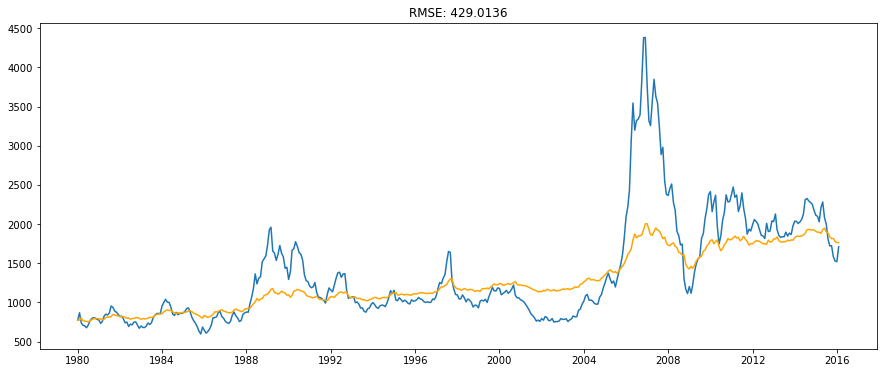

In [43]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA, color='orange')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
plt.show()

In [5]:
import numpy as np
np.exp(-4) * 1

0.01831563888873418